In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

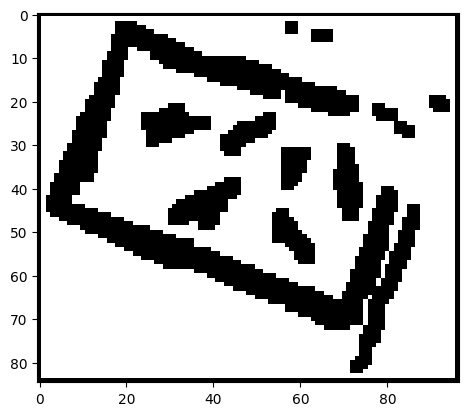

In [2]:
bitmap = np.load('map.npy')
plt.imshow(bitmap.transpose(), cmap='gray')

In [3]:
pos = dict()
graph = nx.DiGraph()

In [4]:
def check_intersection(origin_point, vector, max_dist, only_bool=False):
    
    line = np.linspace(origin_point, origin_point+vector, 10, endpoint=True)
    try:
        i = [bitmap[*np.round(point).astype(int)] for point in line].index(False)
        if only_bool:
            return False
        return None if norm(line[i-1]-origin_point) < 0.3*max_dist else line[i-1]
    except ValueError:
        if only_bool:
            return True
        return origin_point+vector

In [14]:
def update_graph(graph: nx.DiGraph, point, max_dist: float) -> int | None:
    
    closest = min(graph, key = lambda node: norm(pos[node]-point))
    projection = max_dist*(point-pos[closest])/norm(point-pos[closest])
    new_point = point if norm(point-pos[closest]) < norm(projection) else pos[closest] + projection
    
    new_point = check_intersection(pos[closest], new_point-pos[closest], max_dist)
    
    if new_point is None:
        return
    
    node = len(pos)
    pos[node] = new_point
    graph.add_node(node)
    graph.add_edge(closest, node)
    return node

RRT

Path length: 91.59779101712364


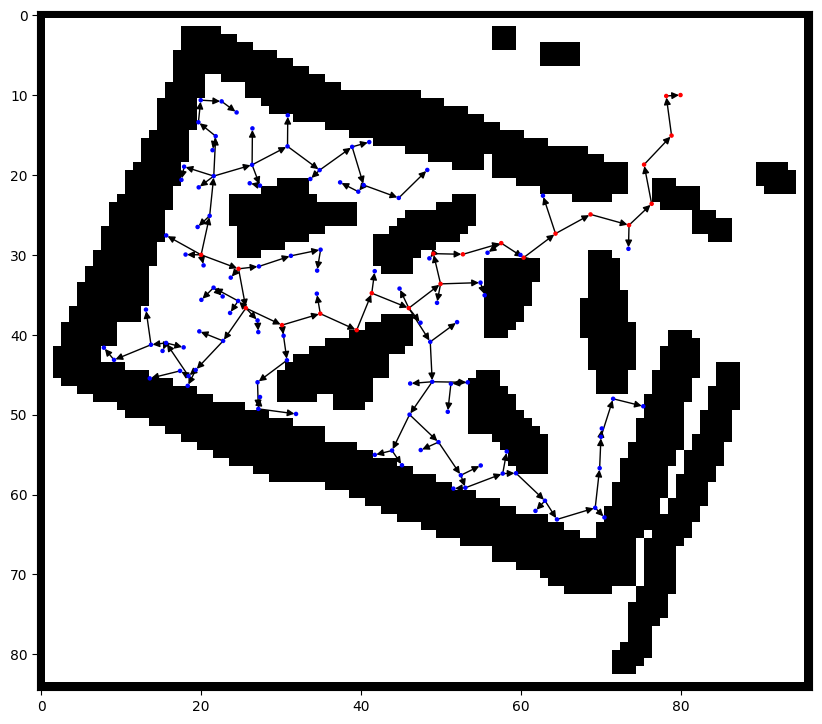

In [6]:
SEGMENT = 5
pos = dict()
graph = nx.DiGraph()
START = np.array([20., 30.])
FINISH = np.array([80., 10.])
pos[0] = START
graph.add_node(0)

while True:
    new_point = np.random.random(2)*(np.array(bitmap.shape)-np.ones(2))
    added_node = update_graph(graph, new_point, SEGMENT)
    
    if not added_node or norm(pos[added_node]-FINISH) > SEGMENT:
        continue
    
    if check_intersection(pos[added_node], FINISH-pos[added_node], SEGMENT, True):
        node = len(pos)
        pos[node] = FINISH
        graph.add_node(node)
        graph.add_edge(node-1, node)
        break

path = [len(pos)-1]
while path[-1]:
    path.append(*graph.predecessors(path[-1]))

print('Path length:', sum([norm(pos[node]-pos[path[i]]) for i, node in enumerate(path[1:])]))
plt.figure(figsize=(10, 10))
color_map = ['red' if node in path else 'blue' for node in graph]
plt.imshow(bitmap.transpose(), cmap='gray', aspect='equal')
nx.draw(graph, pos, node_size=5, node_color=color_map, width=1)
plt.axis('on')
plt.gca().tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

RRT-connect

Path length: 146.10496128785164


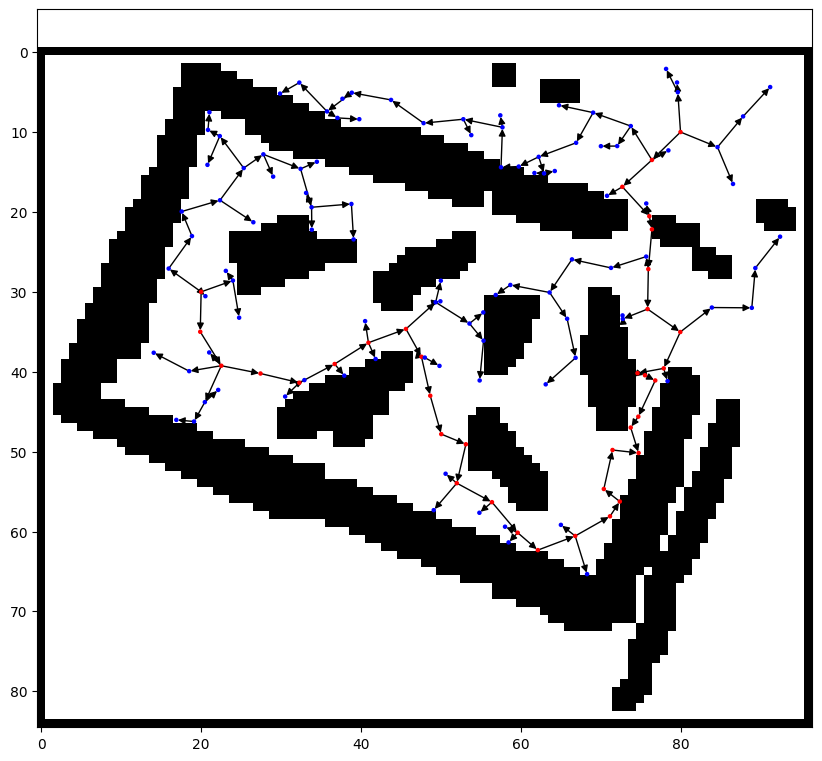

In [15]:
pos = dict()
graph_start = nx.DiGraph()
graph_finish = nx.DiGraph()
START = np.array([20., 30.])
FINISH = np.array([80., 10.])
SEGMENT = 5
pos[0] = START
graph_start.add_node(0)
pos[1] = FINISH
graph_finish.add_node(1)
graph = nx.Graph()


def check_if_connects(node: int, graph: nx.Graph, max_dist: float) -> int | bool:

    dist = {i : norm(pos[node]-pos[i]) for i in graph}
    closest = min(dist, key=dist.get) # type: ignore
    if dist[closest] <= max_dist:
        return closest
    return False


path = list()
while True:  
    # graph_start
    random_point = np.random.random(2)*(np.array(bitmap.shape)-np.ones(2))
    added_node = update_graph(graph_start, random_point, SEGMENT)
    if added_node and (connects := check_if_connects(added_node, graph_finish, SEGMENT)):
        if check_intersection(pos[added_node], pos[connects]-pos[added_node], SEGMENT, True):
            graph: nx.Graph = nx.compose(graph_start, graph_finish)
            graph.add_edge(added_node, connects)
            
            # final path
            path = [added_node, connects]
            break
    
    # graph_finish
    random_point = np.random.random(2)*(np.array(bitmap.shape)-np.ones(2))
    added_node = update_graph(graph_finish, random_point, SEGMENT)
    if added_node and (connects := check_if_connects(added_node, graph_start, SEGMENT)):
        if check_intersection(pos[added_node], pos[connects]-pos[added_node], SEGMENT, True):
            graph: nx.Graph = nx.compose(graph_start, graph_finish)
            graph.add_edge(added_node, connects)
            
            # final path
            path = [connects, added_node]
            break
    
    
while path[-1] != 1:
    path.append(*graph_finish.predecessors(path[-1]))
while path[0] != 0:
    path.insert(0, *graph_start.predecessors(path[0]))

    
print('Path length:', sum([norm(pos[node]-pos[path[i]]) for i, node in enumerate(path[1:])]))
plt.figure(figsize=(10, 10))
plt.imshow(bitmap.transpose(), cmap='gray', aspect='equal')
color_map = ['red' if node in path else 'blue' for node in graph]
nx.draw(graph, pos, node_size=5, node_color=color_map, width=1)
plt.axis('on')
plt.gca().tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

RRT*

In [8]:
def recalculate_weights(graph: nx.DiGraph, root: int):
    for node in nx.descendants(graph, root):
        pred = next(graph.predecessors(node))
        graph.nodes[node]['weight'] = graph.nodes[pred]['weight'] + norm(pos[pred] - pos[node])


def update_graph(graph: nx.DiGraph, point, max_dist: float) -> int | None:
    
    closest = min(graph, key = lambda node: norm(pos[node]-point))
    projection = max_dist*(point-pos[closest])/norm(point-pos[closest])
    new_point = point if norm(point-pos[closest]) < norm(projection) else pos[closest] + projection
    
    neighbours = {node : graph.nodes[node]['weight'] + norm(pos[node]-new_point)
                  for node in pos
                  if norm(pos[node]-new_point) <= SEGMENT*3 and 
                  check_intersection(pos[node], new_point-pos[node], max_dist, True)}
    
    if not neighbours:
        return
    
    node = len(pos)
    pos[node] = new_point
    best_neighbour = min(neighbours, key=neighbours.get) # type: ignore
    graph.add_node(node, weight=graph.nodes[best_neighbour]['weight'] + norm(pos[best_neighbour]-new_point))
    graph.add_edge(best_neighbour, node)
    
    for neighbour in neighbours:
        if graph.nodes[neighbour]['weight'] > graph.nodes[node]['weight'] + norm(pos[neighbour]-new_point):
            graph.remove_edge(list(graph.predecessors(neighbour))[0], neighbour)
            graph.add_edge(node, neighbour)
            
    recalculate_weights(graph, node)
    return node

Path length: 117.80956138103777


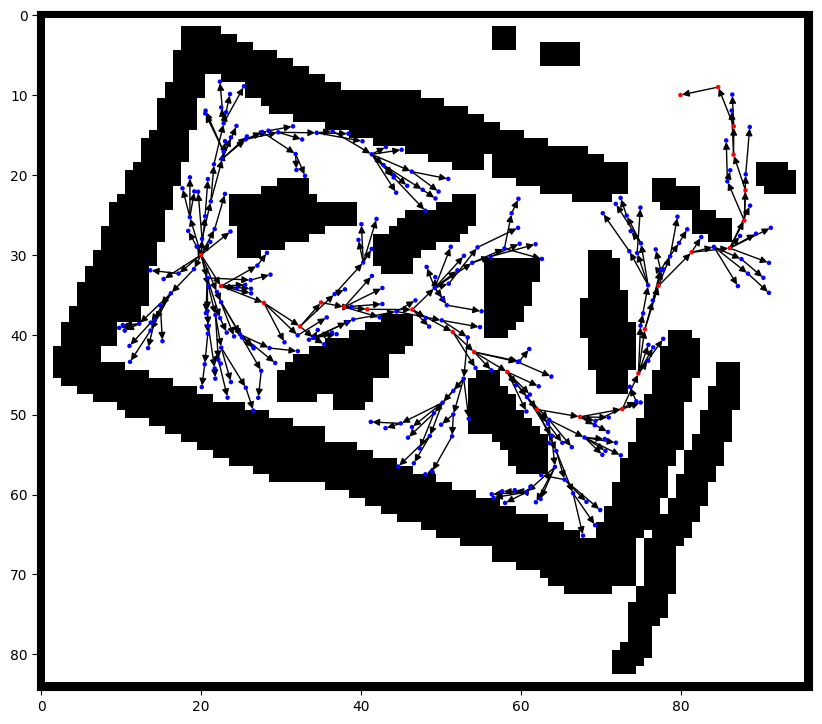

In [9]:
pos = dict()
graph = nx.DiGraph()
START = np.array([20., 30.])
FINISH = np.array([80., 10.])
SEGMENT = 2
pos[0] = START
graph.add_node(0, weight=0.)
finish_node = None

while True:
    new_point = np.random.random(2)*(np.array(bitmap.shape)-np.ones(2))
    added_node = update_graph(graph, new_point, SEGMENT)
    
    if not added_node:
        continue
    
    dist_to_finish = norm(pos[added_node] - FINISH)
    if dist_to_finish < 3*SEGMENT and check_intersection(new_point, FINISH-new_point, 3*SEGMENT, True):
        node = len(pos)
        pos[node] = FINISH
        finish_node = node
        graph.add_node(node, weight=graph.nodes[added_node]['weight'] + dist_to_finish)
        graph.add_edge(added_node, node)
        break

path = [finish_node]
while path[-1]:
    path.append(*graph.predecessors(path[-1]))
    
plt.figure(figsize=(10, 10))
color_map = ['red' if node in path else 'blue' for node in graph]
plt.imshow(bitmap.transpose(), cmap='gray', aspect='equal')
nx.draw(graph, pos, node_size=5, node_color=color_map, width=1)
plt.axis('on')
plt.gca().tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
print('Path length:', graph.nodes[finish_node]['weight'])

Find better path

Path length: 69.82928111885819


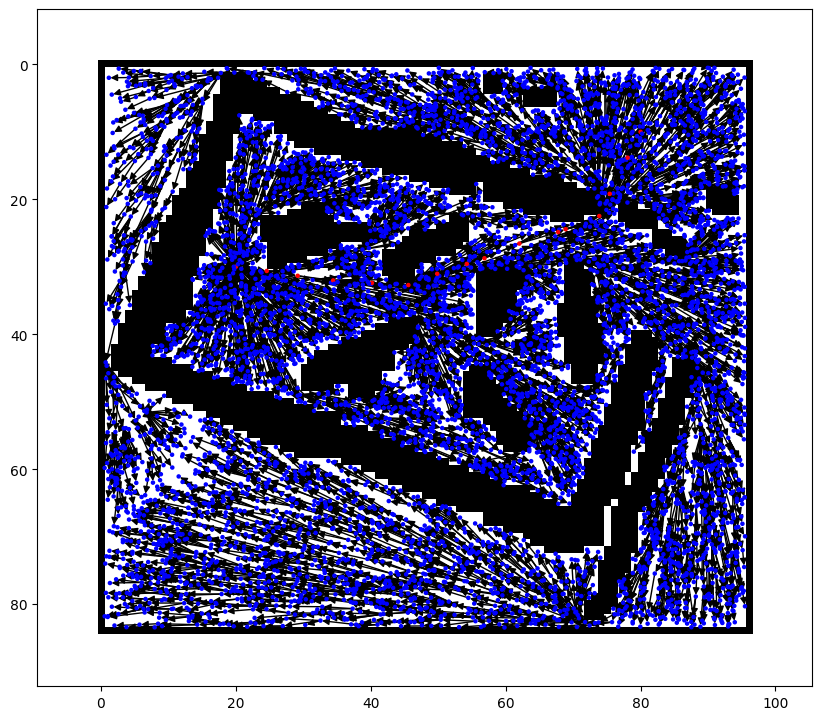

In [10]:
for _ in range(10000):
    new_point = np.random.random(2)*(np.array(bitmap.shape)-np.ones(2))
    added_node = update_graph(graph, new_point, SEGMENT)
    
    if not added_node:
        continue

path = [finish_node]
while path[-1]:
    path.append(*graph.predecessors(path[-1]))
    
plt.figure(figsize=(10, 10))
color_map = ['red' if node in path else 'blue' for node in graph]
plt.imshow(bitmap.transpose(), cmap='gray', aspect='equal')
nx.draw(graph, pos, node_size=5, node_color=color_map, width=1)
plt.axis('on')
plt.gca().tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
print('Path length:', graph.nodes[finish_node]['weight'])